In [1]:
import os
import random
import gc
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from IPython.display import clear_output
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

scaler = MinMaxScaler()
root_directory = 'semantic_segmentation_dataset/'
patch_size = 256

Segmentation Models: using `keras` framework.


In [2]:
# Read images from repsective 'images' subdirectory
# As all images are of different size we have 2 options, either resize or crop
# But, some images are too large and some small. Resizing will change the size of real objects.
# Therefore, we will crop them to a nearest size divisible by 256 and then 
# divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   # Find all 'images' directories
        images = os.listdir(path)  # List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):  
                image = cv2.imread(path+"/"+image_name, 1)  # Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size # Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size 
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  # Crop from top left corner
                image = np.array(image)             
       
                # Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        # Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        single_patch_img = single_patch_img[0] # Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

Now patchifying image: semantic_segmentation_dataset/Tile 1\images/image_part_001.jpg
Now patchifying image: semantic_segmentation_dataset/Tile 1\images/image_part_002.jpg
Now patchifying image: semantic_segmentation_dataset/Tile 1\images/image_part_003.jpg
Now patchifying image: semantic_segmentation_dataset/Tile 1\images/image_part_004.jpg
Now patchifying image: semantic_segmentation_dataset/Tile 1\images/image_part_005.jpg
Now patchifying image: semantic_segmentation_dataset/Tile 1\images/image_part_006.jpg
Now patchifying image: semantic_segmentation_dataset/Tile 1\images/image_part_007.jpg
Now patchifying image: semantic_segmentation_dataset/Tile 1\images/image_part_008.jpg
Now patchifying image: semantic_segmentation_dataset/Tile 1\images/image_part_009.jpg
Now patchifying image: semantic_segmentation_dataset/Tile 2\images/image_part_001.jpg
Now patchifying image: semantic_segmentation_dataset/Tile 2\images/image_part_002.jpg
Now patchifying image: semantic_segmentation_dataset/T

In [3]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   # Find all 'images' directories
        masks = os.listdir(path)  # List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   # Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  # Read each image as grayscale 
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size # Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size 
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  # Crop from top left corner
                mask = np.array(mask)             
       
                # Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  # Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0] # Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 

Now patchifying mask: semantic_segmentation_dataset/Tile 1\masks/image_part_001.png
Now patchifying mask: semantic_segmentation_dataset/Tile 1\masks/image_part_002.png
Now patchifying mask: semantic_segmentation_dataset/Tile 1\masks/image_part_003.png
Now patchifying mask: semantic_segmentation_dataset/Tile 1\masks/image_part_004.png
Now patchifying mask: semantic_segmentation_dataset/Tile 1\masks/image_part_005.png
Now patchifying mask: semantic_segmentation_dataset/Tile 1\masks/image_part_006.png
Now patchifying mask: semantic_segmentation_dataset/Tile 1\masks/image_part_007.png
Now patchifying mask: semantic_segmentation_dataset/Tile 1\masks/image_part_008.png
Now patchifying mask: semantic_segmentation_dataset/Tile 1\masks/image_part_009.png
Now patchifying mask: semantic_segmentation_dataset/Tile 2\masks/image_part_001.png
Now patchifying mask: semantic_segmentation_dataset/Tile 2\masks/image_part_002.png
Now patchifying mask: semantic_segmentation_dataset/Tile 2\masks/image_part_

In [4]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

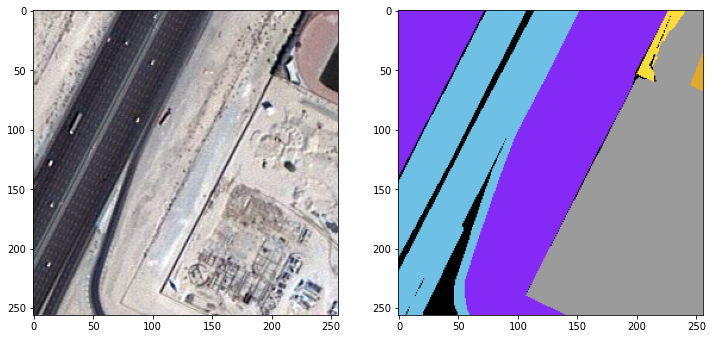

In [5]:
# Sanity check, view few mages
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

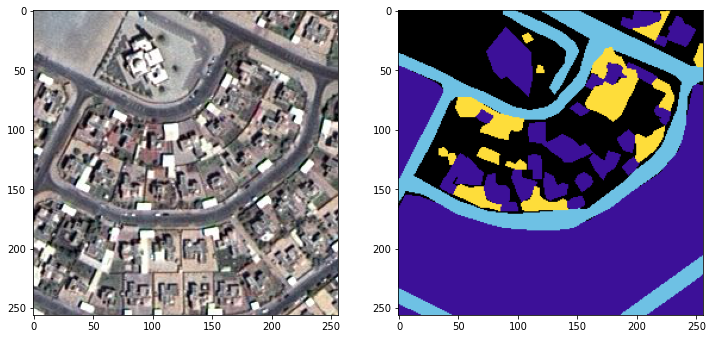

In [28]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()


In [7]:
# Convert HEX to RGB array
building = '#3C1098'.lstrip('#')
building = np.array(tuple(int(building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

land = '#8429F6'.lstrip('#')
land = np.array(tuple(int(land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

road = '#6EC1E4'.lstrip('#') 
road = np.array(tuple(int(road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

vegetation =  'FEDD3A'.lstrip('#') 
vegetation = np.array(tuple(int(vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

water = 'E2A929'.lstrip('#') 
water = np.array(tuple(int(water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

unlabeled = '#9B9B9B'.lstrip('#') 
unlabeled = np.array(tuple(int(unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

60


In [8]:
# Change RGB values to class integers
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == building, axis=-1)] = 0
    label_seg [np.all(label == land, axis=-1)] = 1
    label_seg [np.all(label == road, axis=-1)] = 2
    label_seg [np.all(label == vegetation, axis=-1)] = 3
    label_seg [np.all(label == water, axis=-1)] = 4
    label_seg [np.all(label == unlabeled, axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  
    
    return label_seg

In [9]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


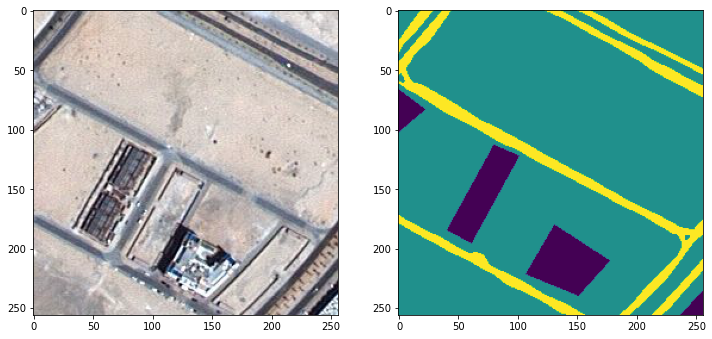

In [10]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [11]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

from unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [13]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
131/131 [==============================] - 35s 211ms/step - loss: 0.9885 - accuracy: 0.5712 - jacard_coef: 0.2910 - val_loss: 0.9687 - val_accuracy: 0.6993 - val_jacard_coef: 0.4187
Epoch 2/100
131/131 [==============================] - 15s 116ms/step - loss: 0.9626 - accuracy: 0.7010 - jacard_coef: 0.4339 - val_loss: 0.9553 - val_accuracy: 0.7444 - val_jacard_coef: 0.5248
Epoch 3/100
131/131 [==============================] - 15s 116ms/step - loss: 0.9530 - accuracy: 0.7327 - jacard_coef: 0.4884 - val_loss: 0.9465 - val_accuracy: 0.7622 - val_jacard_coef: 0.5423
Epoch 4/100
131/131 [==============================] - 15s 116ms/step - loss: 0.9462 - accuracy: 0.7575 - jacard_coef: 0.5260 - val_loss: 0.9381 - val_accuracy: 0.7868 - val_jacard_coef: 0.5825
Epoch 5/100
131/131 [==============================] - 15s 116ms/step - loss: 0.9373 - accuracy: 0.7863 - jacard_coef: 0.5736 - val_loss: 0.9353 - val_accuracy: 0.7997 - val_jacard_coef: 0.5987
Epoch 6/100
131/131 [=========

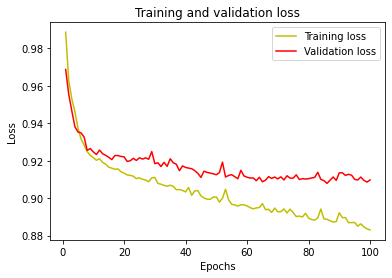

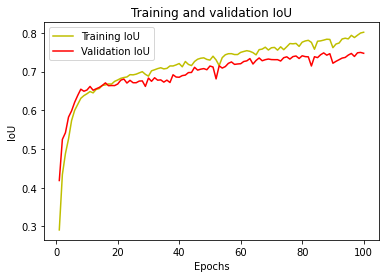

In [14]:
# Plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


In [22]:
X_test.shape

(261, 256, 256, 3)

In [25]:
import gc
X_train = None
y_train = None
gc.collect()

21170

In [26]:
#IOU
y_pred=model.predict(X_test, batch_size=4)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.61422247


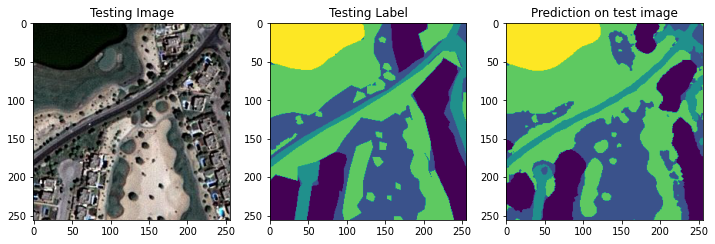

In [27]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

